<a href="https://colab.research.google.com/github/lukasdekanovsky/Become_PythonDeveloper_AI/blob/main/X_STROJOV%C3%89_U%C4%8CEN%C3%8D_(CL)_Skal%C3%A1rn%C3%AD_regrese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neuronová síť regresní** - predikce hodnot/regrese

Pokusíme se odhadnout medián ceny domů v daném předměstí Bostonu v polovině sedmdesátých let vzhledem k informacím o předměstí v té době jako je míra kriminality, místní daňová sazba atd.
* K tomu slouží datová množina **Boston_housing**

* Datová množina obsahuje 506 údajů rozdělených na 404 trénovacích a 102 testovacích
* Každý příznak ve vstupních datech (např. míra kriminality) jiný rozsah 0-1, 1-12, 0-100 at...

# **Načtení datové množiny**

In [ ]:
import tensorflow as tf

In [ ]:
(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

# **Prohlédnutí dat**

1) Prohlédnutí dat - jaký mají shape (kolik)

In [ ]:
train_data.shape
#                 (404, 13) = 404 trénovacích dat a každý má 13 číselných znaků jako je míra kriminality na obyvatele, průměrný počet pokojů atd..

(404, 13)

In [ ]:
test_data.shape
#                 (102, 13)

(102, 13)

2) Prohlédnutí targetů - mediánové hodnoty domů v tisících dolarů

In [ ]:
train_targets
#                 array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1, ......])

# **Příprava dat**
* Jelikož mají naše hodnoty různá rozmezí, provádíme normalizaci
* = pro každý sloupec v matici vstupních dat odečteme od hodnot průměr a dělíme std odchylkou, takže výsledek bude centrován kolem 0 a bude mít směrodatnou odchylku 1

1) Normalizace vstupních dat
* provedeno na train_data a test_data

In [ ]:
# train_data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
# test_data
test_data -= mean
test_data /= std

# **Tvorba naší sítě**

Vzhledem k tomu, že je k dispozici jen málo příkladů, použijeme velmi malou síť jen se dvěma skrytými vrstvami, z nichž každá má 64 jednotek
* Obecně platí, že čím méně trénovacích údajů máme, tím horší je přeučení.
* Používání malých sítí je jedním ze způsobů, jak přeučení zmírnit.


In [ ]:
 #                    tvoříme model jako funkci, protože budeme muset vytvářet její instanci opakovaně
 def build_model():
   model = tf.keras.models.Sequential()
   model.add(tf.keras.layers.Dense(64, activation="relu",
                                   input_shape=(train_data.shape[1],)))
   model.add(tf.keras.layers.Dense(64, activation="relu"))
   model.add(tf.keras.layers.Dense(1))
   model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
   return model


* Síť končí jedinou jednotkou a žádnou aktivací (bude to linární vrstva)
= typické pro skalární regrese (pokoušíme se predikovat jednu spojitou hodnotu)
= použití aktivační funkce by mohlo omezit rozsah výstupu
* Jelikož neuvádíme aktivační funkci, může se síť naučit predikovat hodnoty v libovolném rozsahu, protože poslední vrstva je čistě lineární
* Ztrátová funkce **mse** - střední kvadratická chyba = čtverec rozdílu mezi predikcí a cílem
* trénovací metrika **mae** - střední absolutní chybu, je to aboslutní hodnota mezi predikcí a cílem = MAE s hodnotou 0,5 by znamenala, že naše predikce se v průměru liší o 500 dolarů

# **U regresí aplikujeme K-násobné validace** - pokud máme nedostatek validačních dat = validační skóre se může hodně měnit v závislosti na typu použitých dat

# **+ Trénink modelu a validace**

* tzv. **K-fold** nebo také **cross-validation** spočívá v rozdělení dostupnch dat na K částí (4, 5..)
* Vytvoření K instancí identických modelů a trénování každého na K-1 částech a použití zbývající části k validaci
* Validační skore použitého modelu je pak průměr z K obdržených validačních skóre

In [ ]:
import numpy as np

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print("Processing fold #", i)
  # připraví validační data z oddílu (i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # připraví trénovací data ze všech ostatních oddílů
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  # Vytvoříme model Kerasu - již  zkompilovaný
  model = build_model()
  # Trénuje model
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  # Vyhodnotí model na validačních datech
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


Spuštění tohoto programu s num_epochs = 100 poskytuje následující výsledky:

In [ ]:
print(all_scores)

[2.245640754699707, 2.4709622859954834, 3.100998640060425, 2.399486780166626]


In [ ]:
print(np.mean(all_scores))

2.5542721152305603


Různé běhy ukazují poněkud odlišné validační skóre od 2.2-3.1 kdežto průměr 2.6 je mnohem spolehlivější

* v tomto případě se průměrně odchylujeme od 2500 dolarů což je při rozptylu cen 10k-50k docela významné
* provedeme proto trénování na 500 epoch a nyní budeme pozorovat jak model pracuje v každé epoše

# **Úprava modelu zvýšením epoch**

In [ ]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print("Processing fold #", i)
  # připraví validační data z oddílu (i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history["val_mean_absolute_error"]
  all_mae_histories.append(mae_history)

In [ ]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


* Vykreslíme si Validační MAE

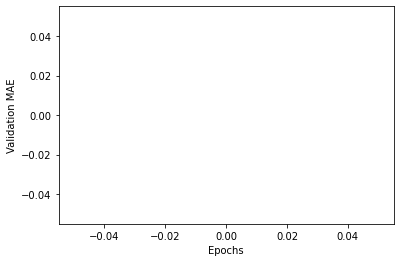

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

# **Ověření správnosti na testovacích datech**

In [ ]:
model=build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 19.1250 - mae: 2.8193


In [ ]:
print(test_mae_score)

2.8193159103393555
